In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets
import numpy as np
import pandas as pd
from adjustText import adjust_text
import random
from model_structure import get_preprocessing_transforms,BCNN, train_model, evaluate_model

In [2]:
INPUT_SIZE = 224
BATCH_SIZE = 32
DEVICE = torch.device('cpu') # torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def read_data():
    # Get transforms
    train_transform, val_transform = get_preprocessing_transforms(INPUT_SIZE)

    test_data_1_dir = 'data4model_1/test/'
    test_data_2_dir = 'data4model_2/test/'
    train_data_1_dir = 'data4model_1/train/'
    train_data_2_dir = 'data4model_2/train/'

    # Load data set
    dataset_test_1 = datasets.ImageFolder(test_data_1_dir,transform=val_transform)
    dataset_train_1 = datasets.ImageFolder(train_data_1_dir,transform=train_transform)
    dataset_test_2 = datasets.ImageFolder(test_data_2_dir,transform=val_transform)
    dataset_train_2 = datasets.ImageFolder(train_data_2_dir,transform=train_transform)

    test_loader_1 = DataLoader(dataset_test_1, shuffle=False, batch_size=BATCH_SIZE)
    train_loader_1 = DataLoader(dataset_train_1, shuffle=False, batch_size=BATCH_SIZE)
    test_loader_2 = DataLoader(dataset_test_2, shuffle=False, batch_size=BATCH_SIZE)
    train_loader_2 = DataLoader(dataset_train_2, shuffle=False, batch_size=BATCH_SIZE)

    return {"Model_1:Train": train_loader_1,
            "Model_1:Test": test_loader_1,
            "Model_2:Train": train_loader_2,
            "Model_2:Test": test_loader_2}

In [4]:
model_1_dir = 'best_model_1.pth'
model_2_dir = 'best_model_2.pth'

In [5]:
# Load the model
model_1 = BCNN().to(DEVICE)
weights = torch.load(model_1_dir, map_location=torch.device(DEVICE))
model_1.load_state_dict(weights)
model_1.eval()

model_2 = BCNN().to(DEVICE)
weights = torch.load(model_2_dir, map_location=torch.device(DEVICE))
model_2.load_state_dict(weights)
model_2.eval()

C:\Users\hskay\AppData\Local\Temp\ipykernel_5800\1438434258.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(model_1_dir, map_location=torch.device(D

BCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout2d(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=1, bias=True)
    (5): Sigm

In [6]:
dataSets = read_data()

In [7]:
for key in dataSets:
    print(key)
    if "Model_1" in key:
        model = model_1
    else:
        model = model_2
    
    results = evaluate_model(model.to(DEVICE), dataSets[key], DEVICE)
    print("Accuracy: ", results[0])
    print("F1 Score: ", results[1])
    print("confusion Matrix: \n",results[3])
    print("\n")

Model_1:Train
Accuracy:  0.9106666666666666
F1 Score:  0.9090291921249152
confusion Matrix: 
 [[1393  107]
 [ 161 1339]]


Model_1:Test
Accuracy:  0.875
F1 Score:  0.8743718592964824
confusion Matrix: 
 [[88 12]
 [13 87]]


Model_2:Train
Accuracy:  0.8926666666666667
F1 Score:  0.8910690121786198
confusion Matrix: 
 [[1361  139]
 [ 183 1317]]


Model_2:Test
Accuracy:  0.905
F1 Score:  0.9090909090909091
confusion Matrix: 
 [[86 14]
 [ 5 95]]




In [128]:
N_NEURONS = 5  # Number of random neurons to monitor
activation_values = {"Model_1":{},
                     "Model_2":{}}



In [129]:
def get_activation(name,model_name):
    def hook(model, input, output):
        activation_values[model_name][name] = output.detach()
    return hook

def register_hooks(model,model_name, N=1):
    hooks = []
    layer_info = {}
    counter = 0
    for name, layer in model.named_modules():
        #if isinstance(layer, (nn.Conv2d, nn.Linear)):
            # Register hook for the full layer output
            hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            
            if isinstance(layer, nn.Linear):
                layer_info[name] = {'type': f'{counter}-linear',}
            elif isinstance(layer, nn.Conv2d):
                layer_info[name] = {'type': f'{counter}-conv'}
            elif isinstance(layer, nn.ReLU):
                layer_info[name] = {'type': f'{counter}-relu'}
            elif isinstance(layer, nn.MaxPool2d):
                layer_info[name] = {'type': f'{counter}-maxpool'}
            elif isinstance(layer, nn.Dropout):
                layer_info[name] = {'type': f'{counter}-dropout'}
            elif isinstance(layer, nn.Flatten):
                layer_info[name] = {'type': f'{counter}-flatten'}
            elif isinstance(layer, nn.Sigmoid):
                layer_info[name] = {'type': f'{counter}-sigmoid'}
            else:
                layer_info[name] = {'type': f'{counter}-other'}
            counter += 1
    return hooks, layer_info

# Function to select random neuron indices
def select_random_neuron_indices(activations, layer_info, n_neurons=1):
    indices = {}
    
    for layer_name, layer_data in layer_info.items():
        activation = activations[layer_name]
        flattened = activation.view(activation.shape[0],-1)
        selected_indices = random.sample(range(flattened.shape[1]), 
                                       min(n_neurons, flattened.shape[1]))
        indices[layer_name] = selected_indices
    
    return indices

# Function to get activations for given indices
def get_activations_for_indices(activations, indices):
    data = {}
    
    for layer_name, layer_indices in indices.items():
        activation = activations[layer_name]
        flattened = activation.view(activation.shape[0],-1)
        selected_activations = flattened[:, layer_indices]
        
        data[layer_name] = {
            'neuron_idx': layer_indices,
            'activation': selected_activations
        }
    
    return data

# Function to process and save activations
def save_activations_to_csv(layer_info, model_name, permutation, pic_index, n_neurons=1):
    data = []
    
    for layer_name, layer_data in layer_info.items():
        # Select random neurons
        selected_indices, selected_activations = permutation[layer_name]['neuron_idx'], permutation[layer_name]['activation']
        
        # Convert to numpy and process each selected neuron
        activation_np = selected_activations.cpu().numpy()
        
        for idx, neuron_idx in enumerate(selected_indices):
            value = activation_np[0, idx]  # Take first batch
            data.append({
                'model': model_name,
                'data_idx': pic_index,
                'layer': layer_name,
                'neuron_idx': neuron_idx,
                'activation': value,
                'layer_type': layer_data['type']
            })
    

    df = pd.DataFrame(data)
    df.to_csv(f'{model_name}_layer_neuron_activations_for{pic_index}.csv', index=False)
    return df

def plot_layer_neuron_activations(df, model_name, pic_index, n_neurons=1):
    # Create a copy of the dataframe to avoid modifying the original
    df = df.copy()
    
    # Replace empty strings in 'layer' column with a placeholder
    df['layer'] = df['layer'].replace('', 'base_layer')
    
    plt.figure(figsize=(15+n_neurons, 8+n_neurons//2))

    # Convert layer names to numeric indices
    unique_layers = df['layer'].unique()
    layer_to_index = {layer: idx for idx, layer in enumerate(unique_layers)}
    df['layer_idx'] = df['layer'].map(layer_to_index)
    
    df_sorted = df.sort_values(['layer_idx', 'neuron_idx'])
    
    # Calculate vertical offset for annotations
    def get_offset(idx, total):
        if total == 1:
            return 0
        return (idx - (total-1)/2) * 0.4
    
    # Create scatter plot
    for layer_type in df_sorted['layer_type'].unique():
        layer_data = df_sorted[df_sorted['layer_type'] == layer_type]
        n_points = len(layer_data)
        
        if n_points == 0:
            continue
            
        scatter = plt.scatter(layer_data['layer_type'], 
                            layer_data['neuron_idx'],
                            s=np.abs(layer_data['activation']) * 500 + 100,  # Use absolute value for size
                            alpha=0.7,
                            c=layer_data['activation'],
                            cmap='viridis',
                            zorder=2)
        
        # Add annotations
        for idx, (_, row) in enumerate(layer_data.iterrows()):
            act_value = f"{row['activation']:.3f}"
            annotation = f"n{row['neuron_idx']}\n({act_value})"
            
            offset = get_offset(idx, n_points)
            
            plt.annotate(annotation,
                        (row['layer_type'], row['neuron_idx']),
                        xytext=(20, offset * 50),
                        textcoords='offset points',
                        fontsize=8,
                        bbox=dict(facecolor='white', 
                                edgecolor='none', 
                                alpha=0.7),
                        arrowprops=dict(arrowstyle='->', 
                                      color='gray',
                                      alpha=0.5),
                        zorder=3)
    
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Layer Type')
    plt.ylabel('Neuron Index')
    plt.title(f'{model_name} - Layer Neuron Activations')
    
    plt.colorbar(scatter, label='Activation Value')
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.savefig(f'{model_name}_layer_neuron_activations_for{pic_index}.png')
    plt.show()


In [130]:
hooks1, layers1 = register_hooks(model_1, "Model_1", N_NEURONS)
hooks2, layers2 = register_hooks(model_2, "Model_2", N_NEURONS)

In [131]:
# Taking a data which is dog
images = [(img, idx) for idx, (img, label) in enumerate(dataSets["Model_1:Test"].dataset) 
            if label == 1] #DONT FORGET TO CHANGE BACK THIS

In [132]:
img, pic_index = random.choice(images)

In [133]:
pic_index

104

In [134]:
with torch.no_grad():
    pred1 = model_1(img.unsqueeze(0).to(DEVICE))
    pred2 = model_2(img.unsqueeze(0).to(DEVICE))

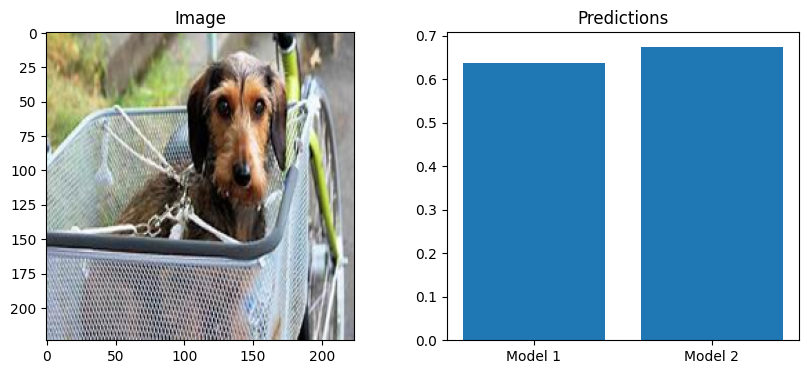

In [135]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))
plt.title('Image')

plt.subplot(1, 2, 2)
plt.bar(['Model 1', 'Model 2'], 
        [pred1.item(), pred2.item()])
plt.title('Predictions')
plt.show()

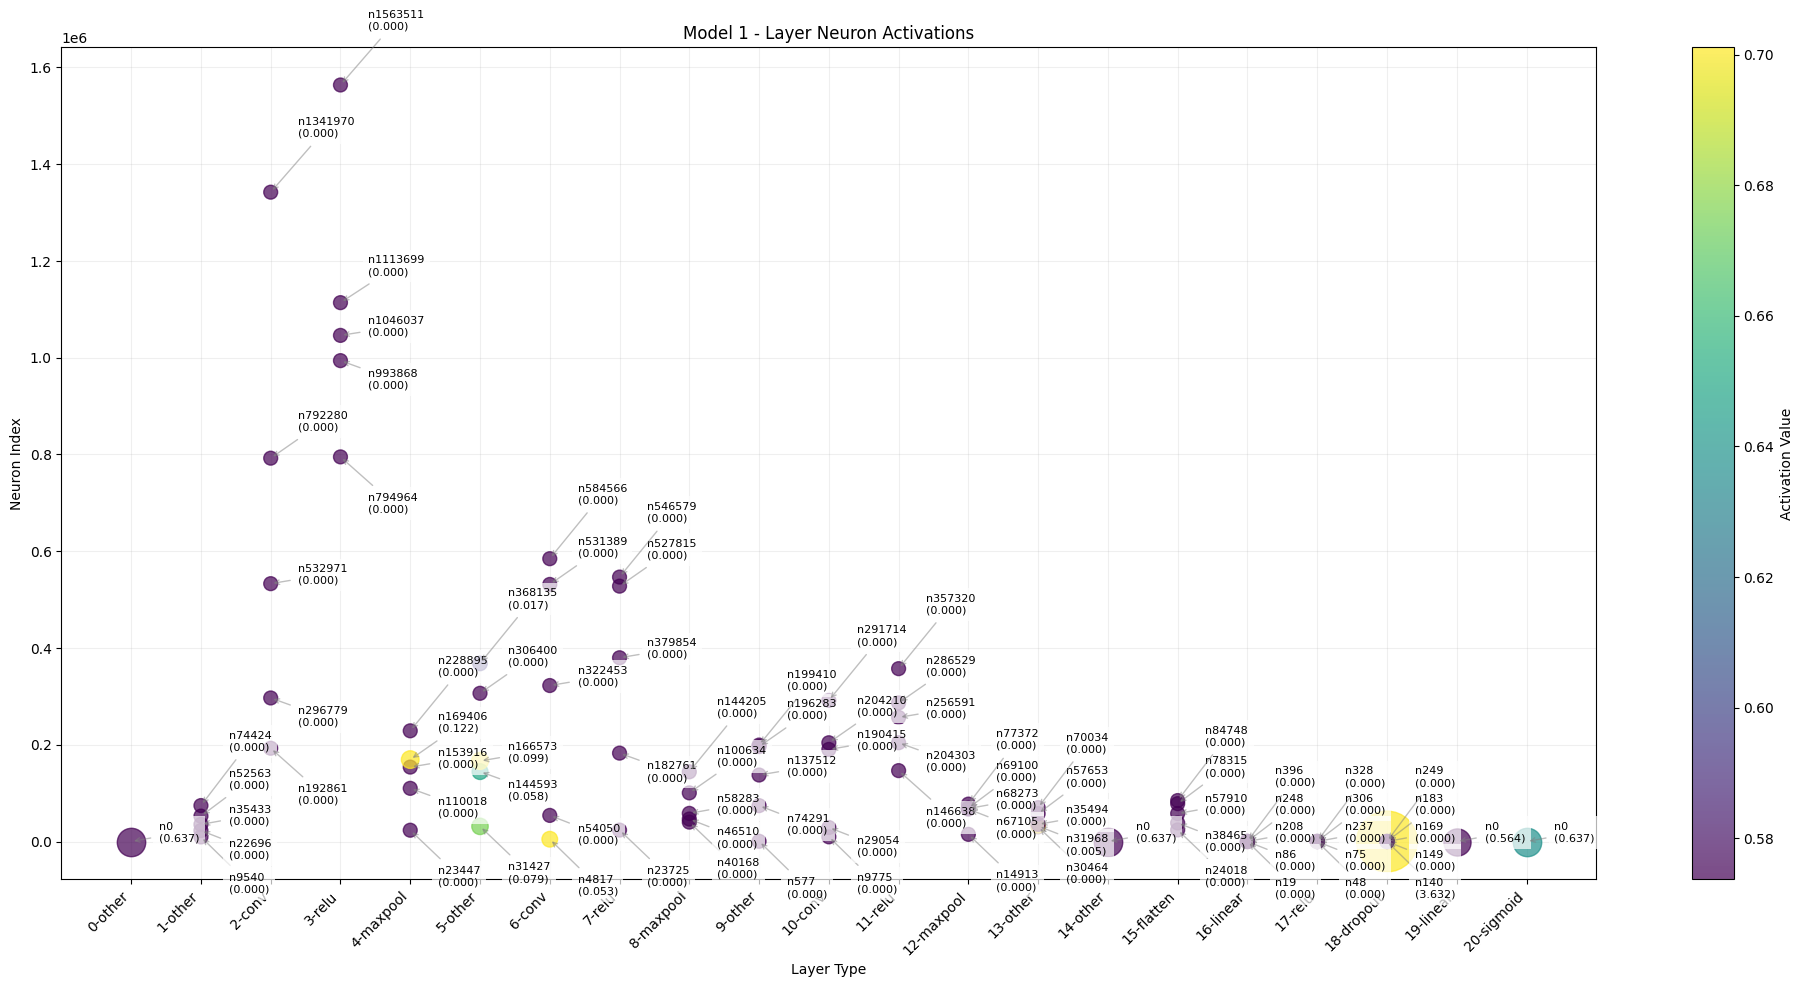

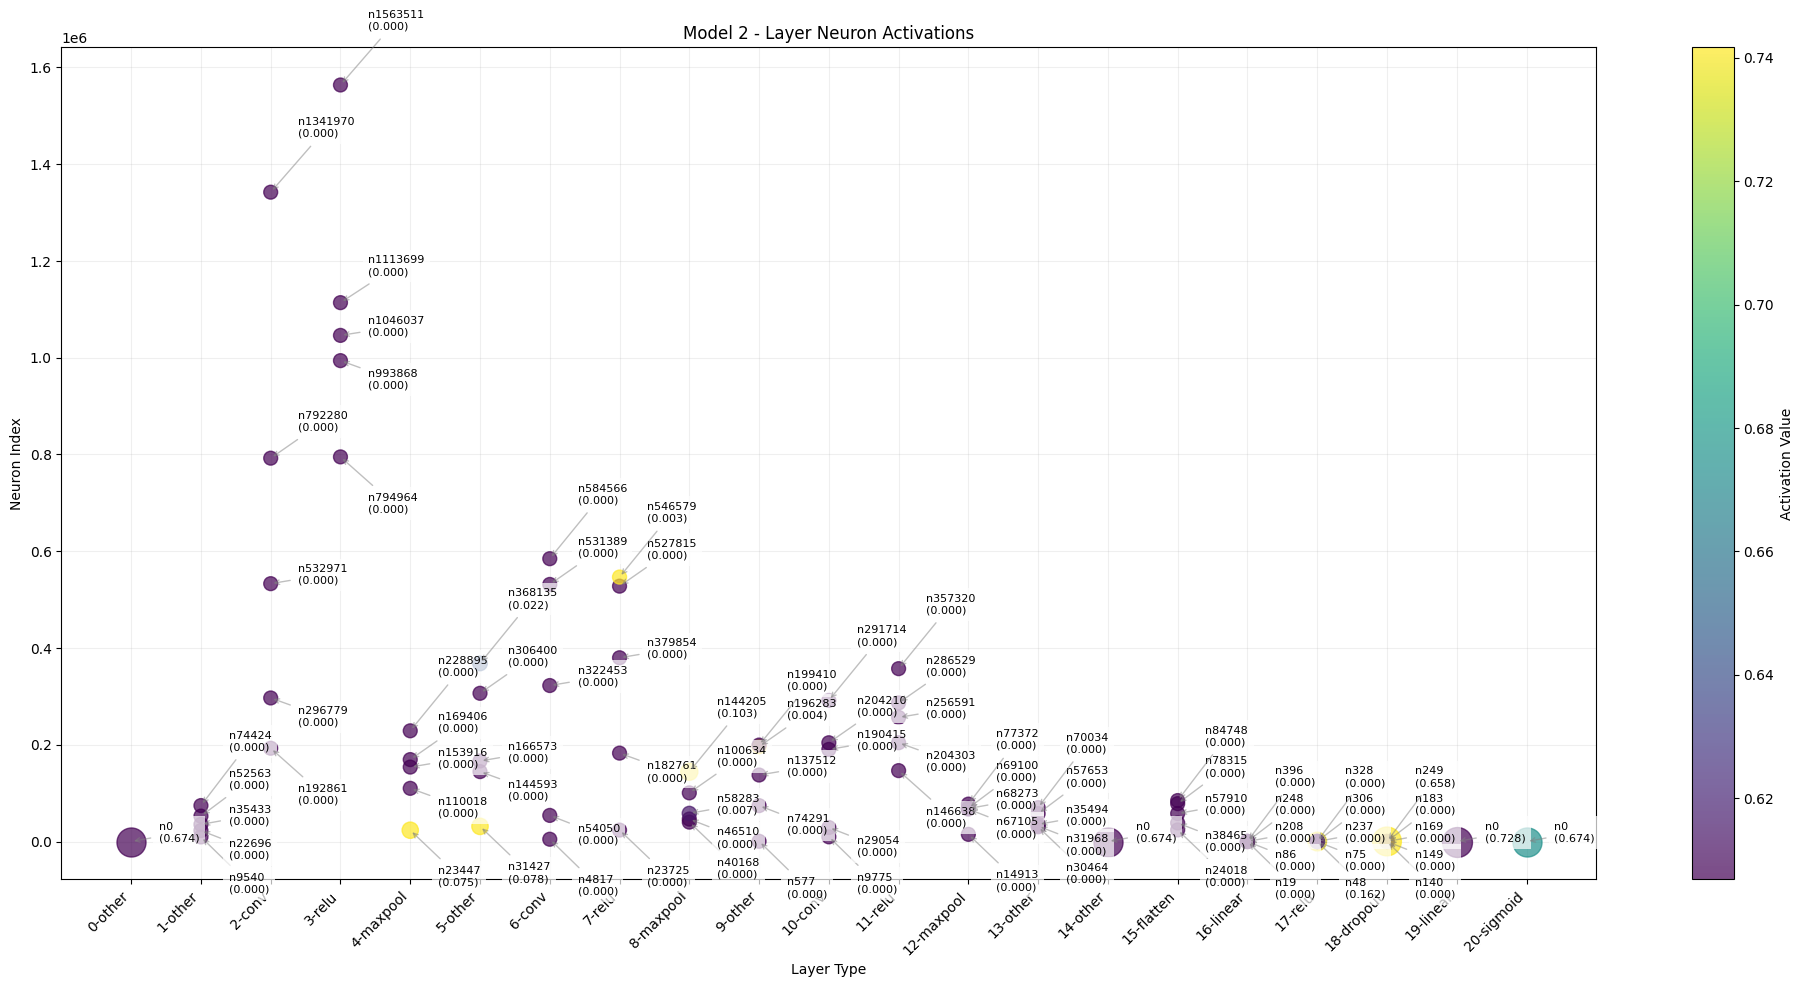

In [136]:
selected_indices = select_random_neuron_indices(activation_values["Model_1"], 
                                              layers1, 
                                              N_NEURONS)

permutation1 = get_activations_for_indices(activation_values["Model_1"], 
                                         selected_indices)
permutation2 = get_activations_for_indices(activation_values["Model_2"], 
                                         selected_indices)

df1= save_activations_to_csv(layers1, 'model1',permutation1, pic_index,  N_NEURONS)
df2 = save_activations_to_csv(layers2, 'model2',permutation2,pic_index, N_NEURONS)
# Plot activations for both models
plot_layer_neuron_activations(df1, 'Model 1',pic_index,N_NEURONS)
plot_layer_neuron_activations(df2, 'Model 2',pic_index,N_NEURONS)


In [137]:
# Remove hooks
for hook in hooks1 + hooks2:
    hook.remove()